# We would like to confirm that more of their resources are dedicated to their customer facing products as the day goes on

### To do this we will have to compare total resource use, by total resources dedicated to their services

It is important for us to take care when adding these that we calculate resources correctly. We will want to look at something like this for every timestamp, for every server, for ever service instance, calculate total resource Util.

In [11]:
import pandas as pd
import numpy as np

In [12]:
service_containers = pd.read_csv("/home/codyblakeney/private/personal_repo/gc_project/data/container_event.csv")

In [13]:
service_instances = pd.read_csv("/home/codyblakeney/private/personal_repo/gc_project/data/container_usage.csv")

In [14]:
ids_at_39600 = np.array(service_instances[service_instances.ts == 39600].instance_id)

In [15]:
service_containers[service_containers.instance_id == ids_at_39600[0]]

,ts,event,instance_id,machine_id,plan_cpu,plan_mem,plan_disk,cpuset,Unnamed: 8
1428,0,Create,117,823,4,0.042409,0.034085,40|41|42|43,NaN


In [16]:
service_instances[np.logical_and(service_instances.instance_id == ids_at_39600[0] , service_instances.ts==39600)]

,ts,instance_id,cpu_util,mem_util,disk_util,load1,load5,load15,avg_cpi,avg_mpki,max_cpi,max_mpki
11,39600,117,3.66,38.299999,12.8,0.14,0.18,0.2,0.164531,0.227815,2.046043,3.524049


https://serverfault.com/questions/667078/high-cpu-utilization-but-low-load-average

### Miss match of CPU Util and Linux Load could mean VMs competing for resources

In [17]:
from bokeh.plotting import figure, show
from bokeh.charts import Histogram
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [8]:
p = Histogram(service_instances[service_instances.ts == 39600].load1, bins=15)
show(p)

In [18]:
len(service_instances[service_instances.ts == 39600].load1)

10260

In [4]:
from service_machine import *

## time_stamp_machine returns a dictionary schema is as follows

```
    { 
        machine_id: 
        {
            instance_id: 
            {
                plan_cpu:
                plan_mem:
                plan_disk:
                cpu_set: []
                cpu_util:
                mem_util:
                disk_util:
                load1:
                load5:
             }
         }
     }
```
        

In [12]:
machine_services = time_stamp_machine(39600, service_containers, service_instances)

In [19]:
cpus = []
for instance in machine_services[1]:
    for cpu in machine_services[1][instance]["cpu_set"]:
        cpus.append(int(cpu))
        
cpus.sort()

### As you might expect every CPU is being used. It doesn't appear that there is any overlap on this particular machine

In [21]:
cpus

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63]

# New images

these histograms represent resources used out of total resources available

services cpu util
![title](../figures/39600_service_cpu_util.png)

total cpu util
![title](../figures/39600_total_cpu_util.png)

total cpu difference 
![title](../figures/39600_service_diff_cpu_util.png)

In [19]:
machine_instance = pd.read_csv("/home/codyblakeney/private/personal_repo/gc_project/data/server_usage.csv")

# DO NOT RUN (Takes 3 hours PS. look for start here)

In [23]:
ts_util = {}
for ts in set(service_instances.ts):
    machine_time_stamp = time_stamp_machine(ts, service_containers, service_instances)
    machine_util = {}
    for machine in machine_time_stamp:
        util = 0
        for instance in machine_time_stamp[machine]:
            util += machine_time_stamp[machine][instance]["plan_cpu"] * machine_time_stamp[machine][instance]["cpu_util"]
        machine_util[machine] = util / 64
    ts_util[ts] = machine_util

## Saving data because it take 3 hours to process

In [26]:
with open('data.p', 'wb') as fp:
    pickle.dump(ts_util, fp)

In [51]:
ts_machine_util_diff = {}
for ts in ts_util:
    machine_diff = {}
    for machine in machine_util:
        #print(ts, machine)
        if not machine_instance[np.logical_and(machine_instance.machineID==machine, machine_instance.timestamp==ts)].util_CPU.empty:
            machine_diff[machine] = float(machine_instance[np.logical_and(machine_instance.machineID==machine, machine_instance.timestamp==ts)].util_CPU) - machine_util[machine]
        #print(machine_diff[machine])
    ts_machine_util_diff[ts] = machine_diff

In [52]:
with open('ts_machine_util_diff.p', 'wb') as fp:
    pickle.dump(ts_machine_util_diff, fp)

In [7]:
machine_services = {}
for ts in set(service_instances.ts):
    #machine_service = time_stamp_machine(ts, service_containers, service_instances)
    #machine_services[ts] = machine_service
    ids_at_ts = np.array(service_instances[service_instances.ts == ts].instance_id)
    machines = {}
    for ids in ids_at_ts:
        container = service_containers[service_containers.instance_id == ids]
        instance = service_instances[np.logical_and(service_instances.instance_id == ids, service_instances.ts==ts)]
        
        for machine in container.machine_id:
        	if machine not in machines:
        		machines[machine] = {}
	        	machines[machine][ids] = {
	        							"plan_cpu": int(np.array(container.plan_cpu)[0]),
	        							"plan_mem": float(np.array(container.plan_mem)[0]),
	        							"plan_disk": float(np.array(container.plan_disk)[0]),
	        							"cpu_set": str(np.array(container.cpuset)[0]).split("|"),
	        							"cpu_util": float(np.array(instance.cpu_util)[0]),
	        							"mem_util": float(np.array(instance.mem_util)[0]),
	        							"disk_util": float(np.array(instance.disk_util)[0]),
	        							"load1": float(np.array(instance.load1)[0]),
	        							"load5" : float(np.array(instance.load5)[0])
	        							
	        						}
	        else:
	        	machines[machine][ids] = {
	        							"plan_cpu": int(np.array(container.plan_cpu)[0]),
	        							"plan_mem": float(np.array(container.plan_mem)[0]),
	        							"plan_disk": float(np.array(container.plan_disk)[0]),
	        							"cpu_set": str(np.array(container.cpuset)[0]).split("|"),
	        							"cpu_util": float(np.array(instance.cpu_util)[0]),
	        							"mem_util": float(np.array(instance.mem_util)[0]),
	        							"disk_util": float(np.array(instance.disk_util)[0]),
	        							"load1": float(np.array(instance.load1)[0]),
	        							"load5" : float(np.array(instance.load5)[0])
	        							
	        						}

        
    machine_services[ts] = machines
        
    

In [18]:
with open('service_machines.p', 'wb') as fp:
    pickle.dump(machine_services, fp)

# Start here

In [6]:
import pickle

ts_machine_util_diff = pickle.load( open( "ts_machine_util_diff.p", "rb" ) )
ts_util = pickle.load(open("data.p", "rb"))
machine_services = pickle.load( open( "service_machines.p", "rb" ) )

In [20]:
ts_service_util_sum = {}
for ts in ts_util:
    service_sum = 0
    for machine in ts_util[ts]:
        service_sum += ts_util[ts][machine]
    service_sum /= 1310
    ts_service_util_sum[ts] = service_sum

In [21]:
ts_machine_util_sum = {}
for ts in ts_machine_util_diff:
    machine_sum = 0
    for machine in ts_machine_util_diff[ts]:
        machine_sum += ts_machine_util_diff[ts][machine]
    machine_sum /= 1310
    ts_machine_util_sum[ts] = machine_sum

In [22]:
cpu_utilization_sum = {}
for ts in ts_machine_util_diff:
    cpu_utilization_sum[ts] = sum(machine_instance[machine_instance.timestamp == ts].util_CPU) / 1310

(39600, 43.255278637782304)
(39600, 9.251526482309977)
(39600, 31.33420393124734)


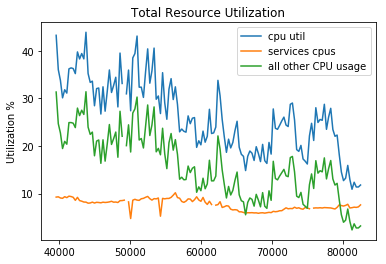

In [23]:
import matplotlib.pylab as plt

lists = sorted(cpu_utilization_sum.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
plt.plot(x, y, label="cpu util")

lists = sorted(ts_service_util_sum.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
plt.plot(x, y, label="services cpus")

lists = sorted(ts_machine_util_sum.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
plt.plot(x, y, label="all other CPU usage")

plt.legend()
plt.title("Total Resource Utilization")
plt.ylabel("Utilization %")

plt.show()

In [24]:
ts_service_util_sum = {}
for ts in ts_util:
    service_sum = 0
    machines = len(ts_util[ts])
    for machine in ts_util[ts]:
        service_sum += ts_util[ts][machine]
    service_sum /= machines
    ts_service_util_sum[ts] = service_sum

In [25]:
ts_machine_util_sum = {}
for ts in ts_machine_util_diff:
    machine_sum = 0
    machines = len(ts_machine_util_diff[ts])
    for machine in ts_machine_util_diff[ts]:
        machine_sum += ts_machine_util_diff[ts][machine]
    machine_sum /= machines
    ts_machine_util_sum[ts] = machine_sum

In [36]:
lower = -1
lowest = 0
for ts in ts_util:
    if ts_service_util_sum[ts] > ts_machine_util_sum[ts] and ts < 70000:
        if ts_service_util_sum[ts] - ts_machine_util_sum[ts] > lowest:
            lowest = ts_service_util_sum[ts] - ts_machine_util_sum[ts]
            lower = ts
            
print("lowest point is ", lower, "with difference of", lowest)

lowest point is  66300 with difference of 0.40532772711883513


In [49]:
higher = -1
highest = 0
for ts in ts_util:
    if ts_service_util_sum[ts] > highest:
        highest = ts_service_util_sum[ts]
        higher = ts
            
print("highest point is ", higher, "with difference of", highest)

highest point is  56400 with difference of 11.770835356532105


In [43]:
300 * 12

3600

In [26]:
cpu_utilization_sum = {}
for ts in ts_machine_util_diff:
    cpu_utilization_sum[ts] = sum(machine_instance[machine_instance.timestamp == ts].util_CPU) / 1310

(39600, 43.255278637782304)
(39600, 10.706271812567199)
(39600, 36.26131373669082)


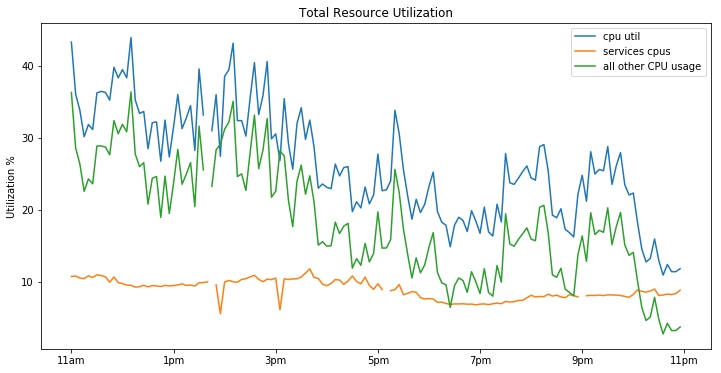

In [46]:
import matplotlib.pylab as plt
timestamps = np.sort((list(set(machine_instance.timestamp))))
lists = sorted(cpu_utilization_sum.items()) # sorted by key, return a list of tuples
plt.figure(figsize=[12,6])
x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
hour = [(z- timestamps[0])/3600  for z in x]
plt.plot(hour, y, label="cpu util")

lists = sorted(ts_service_util_sum.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
hour = [(z- timestamps[0])/3600  for z in x]
plt.plot(hour, y, label="services cpus")

lists = sorted(ts_machine_util_sum.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
hour = [(z- timestamps[0])/3600  for z in x]
plt.plot(hour, y, label="all other CPU usage")
#plt.axvline(x=(66300/3600)-11, color='k', linestyle='--')
labels = ["11am", "1pm", "3pm", "5pm", "7pm", "9pm", "11pm"]
plt.xticks(range(0,14,2), labels)
plt.legend()
plt.title("Total Resource Utilization")
plt.ylabel("Utilization %")

plt.show()

(39600, 43.255278637782304)
(39600, 10.706271812567199)
(39600, 36.26131373669082)


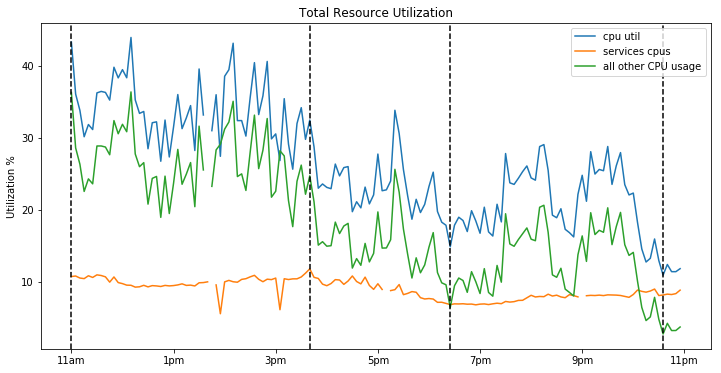

In [50]:
import matplotlib.pylab as plt
timestamps = np.sort((list(set(machine_instance.timestamp))))
lists = sorted(cpu_utilization_sum.items()) # sorted by key, return a list of tuples
plt.figure(figsize=[12,6])
x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
hour = [(z- timestamps[0])/3600  for z in x]
plt.plot(hour, y, label="cpu util")

lists = sorted(ts_service_util_sum.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
hour = [(z- timestamps[0])/3600  for z in x]
plt.plot(hour, y, label="services cpus")

lists = sorted(ts_machine_util_sum.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
print(lists[0])
hour = [(z- timestamps[0])/3600  for z in x]
plt.plot(hour, y, label="all other CPU usage")
plt.axvline(x=(39600/3600)-11, color='k', linestyle='--')
plt.axvline(x=(56400/3600)-11, color='k', linestyle='--')
plt.axvline(x=(66300/3600)-11, color='k', linestyle='--')
plt.axvline(x=(81300/3600)-11, color='k', linestyle='--')
labels = ["11am", "1pm", "3pm", "5pm", "7pm", "9pm", "11pm"]
plt.xticks(range(0,14,2), labels)
plt.legend()
plt.title("Total Resource Utilization")
plt.ylabel("Utilization %")

plt.show()

In [69]:
39600 / (300 * 12)


11.0

In [70]:
80000 / (300 * 12)

22.22222222222222

In [71]:
60000 / (300 * 12)

16.666666666666668

In [72]:
55000 / (300 * 12)

15.277777777777779

In [79]:
from bokeh.charts import HeatMap